# MCMC Analysis of HI Power Spectrum Monopole using simulated Intensity Mapping data

This notebook performs an MCMC analysis on the HI power spectrum monopole. To do this, we use simulated Intensity Mapping data (see `GeneratingLognormalMocks.ipynb` notebook for how this is produced), and a simple no-RSD model for the HI power spectrum that includes the telescope beam damping term. The model is:

$$ P^\mathrm{HI}(\vec{k}) \equiv P^\mathrm{HI}(k, \mu)= \overline{T}_\mathrm{HI}^2 b_\mathrm{HI}^2 \tilde{B}^2_{\mathrm{beam}}(k, \mu)\, P_\text{M}(k) $$

Note that the analysis on this notebook is performed for the case of $z = 0.8$. It can also be performed for $z = 2$ by changing the redshift, input files, and beam size to match the $z = 2$ case. This is outlined in the code where appropriate.

This notebook shows how to reproduce the method used to obtain Fig. 14 in the companion paper, for each redshift. Note that it does not exactly reproduce the final figure, since we use a different plotting method for clarity. To generate the figure as seen in the companion paper, use the python package `GetDist` (https://getdist.readthedocs.io/).

In [1]:
# importing necesary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate

In [2]:
# for plotting:
%matplotlib inline

font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

We start by choosing a redshift and cosmology.

[For $z=2$ case, change redshift here]

In [3]:
zz = 0.8

# Planck15 cosmology:
Om0 = 0.307
H0 = 67.7
h = 0.677

Of particular importance in the model is the telescope beam damping function, which in Fourier space is given by:

$$ \tilde{B}_{\mathrm{beam}}(k, \mu) = \exp\left(\frac{-k^2 R_\text{beam}^2(1-\mu^2)}{2}\right) $$

where $R_\text{beam}$ is the physical "smoothing" scale of the beam at a given redshift, defined as $R_\text{beam} = \sigma_\theta\chi(z)$ where $\sigma_\theta =  \theta_\text{FWHM} / ( 2\sqrt{2\log(2)} )$, $\theta_\text{FWHM}$ is the full-width-half-maximum of the beam in radians and $\chi(z)$ is the comoving distance to the redshift. Below we demonstrate how to calculate this smoothing scale.

For this analysis, and the companion paper, we choose a beam physical smoothing scale of $R_\text{beam} = 14.4$ Mpc/h, equivalent to a beam of $\theta_\text{FWHM} = 1$ deg at $z=0.8$. To achieve the same physical smoothing scale at a different redshift, the corresponding beam size must be recalculated. For example, at $z=2$ we would have $\theta_\text{FWHM} \approx 0.54$.

[For $z=2$ case, change $\theta_\text{FWHM}$ to 0.53983]

In [4]:
# Defining E(z) = H(z)/H0
def E(z):
    E2 = 1 - Om0 + Om0*pow(1+z,3)
    return np.sqrt(E2)

# Hubble constant evolving with z:
def H(z):
    return E(z)*H0

# Comoving distance to redshift z, in units Mpc
def r_comoving(z):
    c_km = 3e5 # speed of light in km per second
    func = lambda z: (c_km/H0)/E(z)
    return integrate.romberg(func,0,z)

# FWHM of telescope beam in degrees:
beam_fwhm = 1
# corresponding physical smoothing scale of beam, in Mpc/h:
R_beam = np.radians(beam_fwhm/(2*np.sqrt(2*np.log(2))))*r_comoving(zz)*h

Next, we demonstrate the effect of the telescope beam damping term for beams of different sizes, as a function of $k_\perp = k \sqrt{1 - \mu ^2}$. We include in the calculation of the beam damping term the foreground modelling, which imposes a varying $\mu$ cut as described in the companion paper. By default this modelling is turned off by setting `k_FG=0` but this parameter is then changed when considering the foreground modelling.

In [5]:
def Beam_factor(k, R, k_FG=0):
    integral = np.zeros(len(k))
    for i in range(len(k)):
        k_i = k[i]
        if k_i==0: k_i = 1e-30 #Avoid divide by k = 0
        mu_FG = k_FG/k_i # for modelling foreground removal we use a varying mu cut, set to 0 otherwise
        if mu_FG>=1: mu_FG=0.9999999999
        mu = np.linspace(mu_FG,1,10000)
        beam_int = np.exp(-(1 - mu**2) * k[i]**2 * R**2)
        integral[i] = 2*integrate.simps(beam_int,mu)
    return 0.5*integral # (1/2) factor arising from the multipole expansion

k_perp = np.linspace(0,0.3,100) # units h/Mpc
R_beams = [1, 10, 20] # different sized beams to test, in units Mpc/h

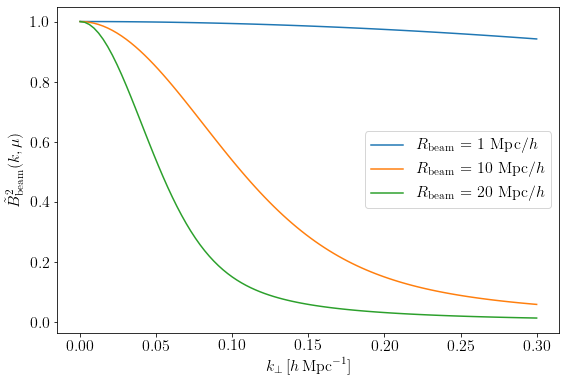

In [6]:
plt.figure(figsize=(9,6))

for R in R_beams:
    plt.plot(k_perp, Beam_factor(k_perp, R), label="$R_\mathrm{beam}$ = "+str(R)+" Mpc/$h$")
    plt.xlabel(r'$k_\perp \, [h\, {\rm Mpc}^{-1}]$')
    plt.ylabel(r'$\tilde{B}^2_{\mathrm{beam}}(k, \mu)$')
    plt.legend()

Finally, we set the fiducial values of the parameters we will wish to constrain with this model.

In [7]:
# fiducial HI density, in units 10^-4:
OmHI_fid = 4.3 # from Masui et al. (2013) [arXiv:1208.0331]
# fiducial HI bias:
bHI_fid = 1

Next, we import our HI power spectrum monopole data, including uncertainties and both the no foreground case and the subtracted foreground case.

[For $z=2$ case, load instead the `Pk0_z=2.dat` file]

In [8]:
# loading power spectrum monopole data, and errors for both the no foreground and subtracted foreground cases:
Pk0_data = np.loadtxt('../inputs/Pk0_z=0.8.dat', comments='#')
k, Pk0_noFG, Pk0_noFG_error, Pk0_subFG, Pk0_subFG_error = Pk0_data

Below we define a function for the HI power spectrum model, considering only the first multipole of the Legendre polynomials expansion (the monopole), given by:

$$ P^\mathrm{HI}_{0}(k) = \frac{1}{2} \overline{T}_\mathrm{HI}^2\, \int_{-1}^{1} \mathrm{d}\mu\, b_\mathrm{HI}^2\, \tilde{B}^2_{\mathrm{beam}}(k, \mu)\, P_\text{M}(k)\,\mathcal{L}_0 $$

where $\mathcal{L}_0 = 1$.

Note that in our model, we calculate $\overline{T}_\mathrm{HI}$ from $\Omega_\mathrm{HI}$ using the relations from Battye et al. (2013) [arxiv:1209.0343]:

$$ \overline{T}_\mathrm{HI}(z) = 180\Omega_{\mathrm{HI}}(z) h \frac{(1+z)^2}{H(z)/H_0} \, {\mathrm{mK}} $$

In [9]:
# HI power spectrum model (monopole)

def Pk_mono(omHIbHI, beam, pdd):
    tHIbHI = 180 * h * (1+zz)**2 * 1e-4 * omHIbHI / (H(zz)/H0) # going from OmHI*bHI to tHI*bHI
    return tHIbHI**2 * beam * pdd # note that the (1/2) factor is included in the beam factor calculation

[For $z=2$ case, load instead the `Pk_z=2.dat` file and set `k_FG=0.031`]

In [10]:
# beam factor:
Beam_k = Beam_factor(k, R_beam)
# underlying linear matter power spectrum, generated using nbodykit (as seen in next cell):
Pdd_k = np.loadtxt('../inputs/Pk_z=0.8.dat', comments='#')
# calculating model:
Pk0_model = Pk_mono(OmHI_fid*bHI_fid, Beam_k, Pdd_k)

# foreground modelling with a varying mu cut:
Beam_kFG = Beam_factor(k, R_beam, k_FG=0.016)
Pk0_modelFG = Pk_mono(OmHI_fid*bHI_fid, Beam_kFG, Pdd_k)

In [11]:
# To calculate your own underlying linear matter power spectrum, using nbodykit:
#from nbodykit.lab import *
#cosmo = cosmology.Planck15
#Pdd = cosmology.LinearPower(cosmo, zz, transfer='EisensteinHu')

Plotting what the monopole data looks like in the no foreground and subtracted foreground cases, as well as the model with fiducial parameters:

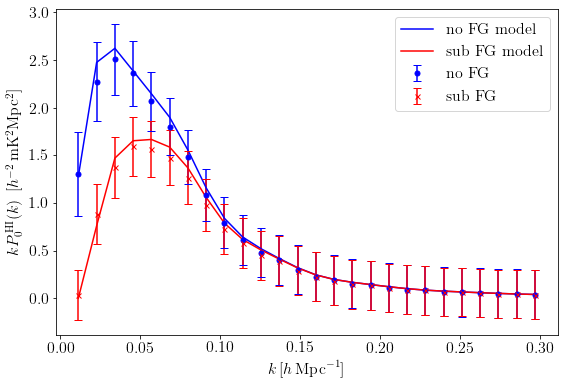

In [12]:
plt.figure(figsize=(9,6))

plt.errorbar(k, k*Pk0_noFG, yerr=k*Pk0_noFG_error, fmt='bo', capsize=4, markersize=5, label='no FG')
plt.plot(k, k*Pk0_model, c='b',label='no FG model')
plt.errorbar(k, k*Pk0_subFG, yerr=k*Pk0_subFG_error, fmt='rx', capsize=4, markersize=5, label='sub FG')
plt.plot(k, k*Pk0_modelFG, c='r',label='sub FG model')
plt.legend()
plt.xlabel(r'$k \, [h\, {\rm Mpc}^{-1}]$')
plt.ylabel("$kP^{\, \mathrm{HI}}_{0}(k)\,$ $[h^{-2}\, \mathrm{mK^2 Mpc^2}]$")

plt.show()

## MCMC

Now we define functions for our model, as well as the prior and likelihood which we will use to run the MCMC analysis. We use the Python package `emcee` for our analysis (https://emcee.readthedocs.io/). 

In [13]:
import emcee

In [14]:
# MCMC functions

# flat positivity prior:
def log_prior(theta):
    OmHIbHI = theta
    if 0 < OmHIbHI < 10000:
        return 0.0
    return -np.inf

# log probability (log likelihood + log prior):
def log_prob(theta, y, yerr, beam, pdd):
    OmHIbHI = theta # parameter we are varying
    diff = np.abs(y - Pk_mono(OmHIbHI, beam, pdd))
    ycov = np.diag(yerr**2) # diagonalise error array, assuming covariance matrix is diagonal
    ll = -0.5*np.dot(diff, np.dot(scipy.linalg.inv(ycov), diff))
    return ll + log_prior(theta) #returns likelihood times prior (posterior)

# function for running MCMC:
def run_emcee(y, yerr, beam, pdd):
    # running emcee:
    pos = [initial + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] # first proposal: initial guess + random noise
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(y, yerr, beam, pdd))
    sampler.run_mcmc(pos, nsamples) # get N samples with MCMC
    samples = sampler.chain[:, 200:, :].reshape((-1, ndim)) # discard first 200 samples (not converged yet) and flatten list
    return samples

In [15]:
# MCMC parameters:
ndim = 1 # number of parameters being probed (1, since the 2 parameters are degenerate)
nwalkers = 200 # number of walkers
nsamples = 500 # number of samples
initial = 2 # initial guess, different from true value

We run MCMC in four different cases:
1. The no foreground case, in the full $k$ range
2. The subtracted foregroud case, in the full $k$ range
3. The subtracted foregroud case, in a restricted $k$ range with an imposed $k_{\rm min}$
4. The subtracted foregroud case, in the full $k$ range and using the foreground modelling technique described in the companion paper, with a $k^\mathrm{FG}_{\parallel}$ cut

[For $z=2$ case, adjust $k_{\rm min}$ cut to `[9:]`, since the survey volume-limited $k_{\rm min}$ and $\Delta k$ are different]

In [21]:
samples_noFG = run_emcee(Pk0_noFG, Pk0_noFG_error, Beam_k, Pdd_k)
samples_subFG = run_emcee(Pk0_subFG, Pk0_subFG_error, Beam_k, Pdd_k)
samples_subFG_kcut = run_emcee(Pk0_subFG[7:], Pk0_subFG_error[7:], Beam_k[7:], Pdd_k[7:]) # cuts at k=0.09 h/Mpc
samples_subFG_FGmodel = run_emcee(Pk0_subFG, Pk0_subFG_error, Beam_kFG, Pdd_k)

# Plotting MCMC results of $\Omega_{\rm HI}b_{\rm HI}$

[For $z=2$ case, adjust the x-axis limits to `plt.xlim(2, 5)`]

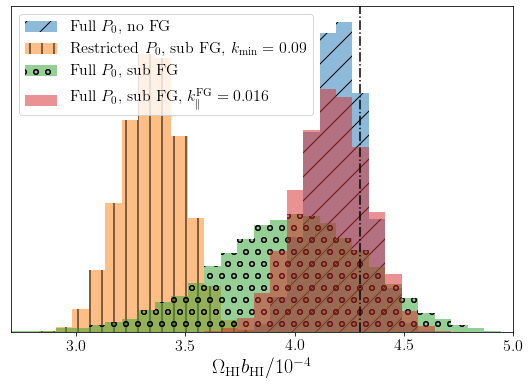

In [22]:
bins = np.linspace(2, 5.7, 50)

plt.figure(figsize=(9,6))

plt.hist(samples_noFG, bins, alpha=0.5, hatch='/', label='Full $P_{0}$, no FG')
plt.hist(samples_subFG, bins, alpha=0.5, hatch='|', label='Restricted $P_{0}$, sub FG, $k_{\mathrm{min}} = 0.09$')
plt.hist(samples_subFG_kcut, bins, alpha=0.5, hatch='o', label='Full $P_{0}$, sub FG')
plt.hist(samples_subFG_FGmodel, bins, alpha=0.5, label='Full $P_{0}$, sub FG, $k^\mathrm{FG}_{\parallel} = 0.016$')
plt.yticks([],[])
plt.xlim(2.7, 5)
plt.axvline(OmHI_fid*bHI_fid, c='k', ls='dashdot')
plt.legend()
plt.xlabel("$\Omega_{\mathrm{HI}}b_{\mathrm{HI}} / 10^{-4} $", fontsize=20)

plt.show()